## Part 1: Demonstration of Differential Privacy using PyDP

### About PyDP
The PyDP package provides access to Differential Privacy algorithms in Python. This example uses the 1.0 version of the package that has the following limitations:

1. This version only supports [Google's Differential Privacy library](https://github.com/google/differential-privacy).
2. Laplace noise generation technique.
3. Supports only integer and floating point values

### What's in this Tutorial
To demonstrate DP, we protect the user from something called Membership Inference Attack(MIA). 

The idea behing DP is we should **not** be able to identify the identity of an individual user.

To prove that, we are going to take a database and create two copies of it such that they differ in only one record. Or exactly one record is absent from the original Database.

#### The Proof

We have generated a synthetic dataset with 5000 records with private information such as name as well as the email of the user. 

The objective of this notebook is going to be able to demonstrate how DP can protect the user from MIA. 

In the dataset at hand, we have the Item spent by the user (sales_amount) of each user. So if we take the sum of the sales_amount and compare it with the sum of sales_amount with the DB which has exactly one less record, we should be able to identify which user has spend how much and hence identify the user, which using the help of DP, we can avoid that. 

In [35]:
!pip install python-dp # installing PyDP

In [36]:
import pydp as dp # by convention our package is to be imported as dp (for Differential Privacy!)
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, Count, Max
import pandas as pd
import statistics # for calculating mean without applying differential privacy
import numpy as np
import matplotlib.pyplot as plt

### Fetching the Data and loading it! 

In [37]:
# get carrots data from our public github repo
url1 = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial%204-Launch_demo/data/01.csv'
df1 = pd.read_csv(url1,sep=",", engine = "python")
df1.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Osbourne,Gillions,ogillions0@feedburner.com,31.94,Florida
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida


In [38]:
url2 = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial%204-Launch_demo/data/02.csv'
df2 = pd.read_csv(url2,sep=",", engine = "python")
df2.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Wallie,Kaman,wkaman0@samsung.com,99.69,Idaho
1,2,Raynard,Tooby,rtooby1@indiegogo.com,208.61,Texas
2,3,Mandie,Stallibrass,mstallibrass2@princeton.edu,42.87,Michigan
3,4,Nonna,Regitz,nregitz3@icq.com,160.94,Iowa
4,5,Barthel,Cowgill,bcowgill4@tiny.cc,179.88,Ohio


In [39]:
url3 = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial%204-Launch_demo/data/03.csv'
df3 = pd.read_csv(url3,sep=",", engine = "python")
df3.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Tomasina,Marcos,tmarcos0@wix.com,161.38,Indiana
1,2,Mill,Yitzhak,myitzhak1@barnesandnoble.com,182.22,Florida
2,3,Hobart,Banaszczyk,hbanaszczyk2@mac.com,41.67,Texas
3,4,Bonita,Benting,bbenting3@smugmug.com,190.26,Indiana
4,5,Kasper,Deyes,kdeyes4@storify.com,177.94,Ohio


In [40]:
url4 = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial%204-Launch_demo/data/04.csv'
df4 = pd.read_csv(url4,sep=",", engine = "python")
df4.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Dylan,Mattocks,dmattocks0@elegantthemes.com,141.90,Wisconsin
1,2,Tully,Pettko,tpettko1@engadget.com,15.09,Missouri
2,3,Ruy,Rodrigo,rrodrigo2@whitehouse.gov,90.72,Florida
3,4,Blakeley,Lower,blower3@macromedia.com,29.87,California
4,5,Horace,Studdert,hstuddert4@theatlantic.com,196.99,Ohio


In [41]:
url5 = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial%204-Launch_demo/data/05.csv'
df5 = pd.read_csv(url5,sep=",", engine = "python")
df5.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Susi,Barker,sbarker0@comsenz.com,220.50,Kentucky
1,2,Gan,Stork,gstork1@who.int,31.75,California
2,3,Corene,Izod,cizod2@wikia.com,163.53,California
3,4,Cornell,Schoales,cschoales3@freewebs.com,59.09,Minnesota
4,5,Petrina,Kennaird,pkennaird4@patch.com,186.38,Georgia


#### Combining the whole data into one single dataframe. 

In [42]:
combined_df_temp = [df1, df2, df3, df4, df5]
original_dataset = pd.concat(combined_df_temp)

The size of the combined dataset: 

In [43]:
original_dataset.shape

(5000, 6)


### Removing 1 record from the DF

Now we create our new dataset for testing DP in which we remove exactly one record from the original DB.

In [44]:
redact_dataset = original_dataset.copy()
redact_dataset = redact_dataset[1:] # this dataset does not have 
# Osbourne	Gillions	ogillions0@feedburner.com	31.94	Florida

In [45]:
original_dataset.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Osbourne,Gillions,ogillions0@feedburner.com,31.94,Florida
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida


In [46]:
redact_dataset.head()

,id,first_name,last_name,email,sales_amount,state
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida
5,6,Elle,McConachie,emcconachie5@census.gov,76.91,Texas


If we find the sum of sales_amount in `total_datset` and `redact_datset`, we should see the difference in the sum to be exactly equal to the money spent  (`sales_amount`) by Osbourne Gillions.

In [47]:
sum_original_dataset = round(sum(original_dataset['sales_amount'].to_list()), 2)
sum_redact_dataset = round(sum(redact_dataset['sales_amount'].to_list()), 2)
sales_amount_Osbourne = round((sum_original_dataset - sum_redact_dataset), 2)

In [48]:
assert sales_amount_Osbourne == original_dataset.iloc[0, 4]

It's quite evident that using the traditional methods, even though if we remove the private information like name and email, we could still infer the identity of the user. 

Using Differential Privacy, we can solve this! 

In [49]:
# we can set the lower bound as 5 because we know the person has to spend minimum of $5 
# while the upper bound as 250 as that's the maximum amount user can spend
# Keeping the datatype as float as the data has floating point numbers.
# if your data has integer only, you should consider using int as it saves a lot of memory
dp_sum_original_dataset = BoundedSum(epsilon= 1.5, lower_bound =  5, upper_bound = 250, dtype ='float') 

In [50]:
dp_sum_og = dp_sum_original_dataset.quick_result(original_dataset['sales_amount'].to_list()) # adding the data to the DP algorithm

In [51]:
dp_sum_og = round(dp_sum_og, 2)
print(dp_sum_og)

636426.66


#### Taking Sum of data on the Redacted Dataset

In [52]:
dp_redact_dataset = BoundedSum(epsilon= 1.5, lower_bound =  5, upper_bound = 250, dtype ='float')
dp_redact_dataset.add_entries(redact_dataset['sales_amount'].to_list())

In [53]:
dp_sum_redact = round(dp_redact_dataset.result(),2)
print(dp_sum_redact)

636737.38


In [54]:
print("Sum of sales_value in the orignal Dataset: {}".format(sum_original_dataset))
print("Sum of sales_value in the orignal Dataset using DP: {}".format(dp_sum_og))
assert dp_sum_og != sum_original_dataset

Sum of sales_value in the orignal Dataset: 636594.59
Sum of sales_value in the orignal Dataset using DP: 636426.66


In [55]:
print("Sum of sales_value in the redacted Dataset: {}".format(sum_redact_dataset))
print("Sum of sales_value in the redacted Dataset using DP: {}".format(dp_sum_redact))
assert dp_sum_redact != sum_redact_dataset

Sum of sales_value in the redacted Dataset: 636562.65
Sum of sales_value in the redacted Dataset using DP: 636737.38


In [56]:
print("Difference in sum using DP: {}".format(round(dp_sum_og - dp_sum_redact, 2)))
print("Actual Value: {}".format(sales_amount_Osbourne))
assert round(dp_sum_og - dp_sum_redact, 2) != sales_amount_Osbourne


Difference in sum using DP: -310.72
Actual Value: 31.94


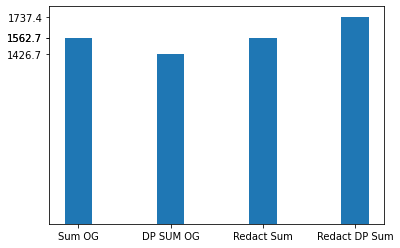

In [57]:
take_diff = 635000
top=[('Sum OG', sum_redact_dataset - take_diff),('DP SUM OG',dp_sum_og- take_diff),('Redact Sum',sum_redact_dataset- take_diff), ('Redact DP Sum',dp_sum_redact - take_diff)]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.3

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()


### Conclusion:
We have demonstrated that using DP, we can protect the data from the MIA attack. 
Also, as it's clearly visible, if we remove one row from our dataset, our results do not vary a lot.